# Lock-In Example

This is an example notebook showing how to use the `lockin` module, which provides software lock-in amplifier classes.

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import sigutils
import lockin

# Overview

Let's generate some example data.

In [2]:
fs = 10e3
T = 1.0
dt = 1/fs
N = int(round(T*fs))
t = np.arange(N)*dt - T/2

def gaussian(x, loc, sigma):
    return np.exp(-(x-loc)**2 / (2*sigma**2))

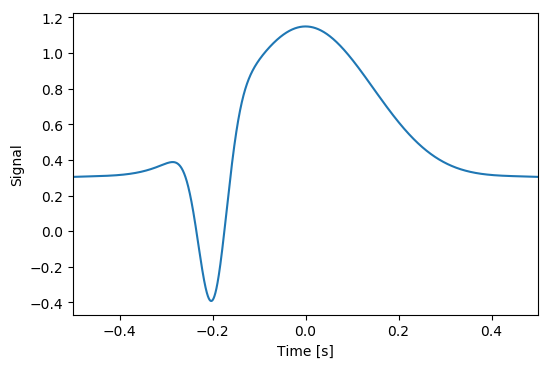

In [3]:
m_noiseless = (
    gaussian(t, 0.0, 0.15) - gaussian(t, -0.2, 0.03)*1 +
    gaussian(t, 0.5, 0.3)*0.3 + gaussian(t, -0.5, 0.3)*0.3
    )
plt.plot(t, m_noiseless)
plt.xlim(-0.5, 0.5)
plt.xlabel("Time [s]")
plt.ylabel("Signal")

This is the expected signal we are hoping our lock-in will recover. Then, we create the modulated signal, and add experimental nosie.

In [4]:
f_m = 500.0 # Modulation frequency
m_modulated = m_noiseless*np.sin(2*np.pi*f_m*t + 0.12)
noise = np.random.randn(N)*0.3
m_measured = m_modulated + noise

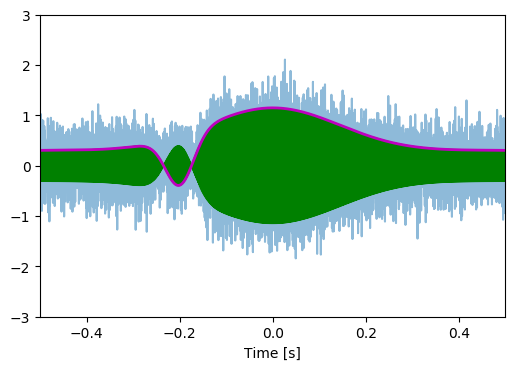

In [5]:
plt.plot(t, m_measured, alpha=0.5)
plt.plot(t, m_modulated, color='g')
plt.plot(t, m_noiseless, color='m', linewidth=2)
plt.xlim(-0.5, 0.5)
plt.ylim(-3, 3)
plt.xlabel("Time [s]")

Now we apply the lock-in amplifier to the modulated signal. First, we create the LockIn object by passing the time array, lock-in input array, and sampling frequency.

In [6]:
li = lockin.LockIn(t, m_measured, fs=fs)

Next, we choose and apply a lock-in filter.  The lock-in filter bandwidth is set by the `bw` argument of the lock function. It is important that the lock-in filter *strongly*  rejects the modulation frequency `f0`.

In [7]:
li.lock(bw=20.0, f0=500.0)

Response:
f   mag       dB
  0.000 1.000    0.000
 10.000 0.996   -0.034
 20.000 0.500   -6.021
250.000 0.000 -137.352
500.000 0.000 -151.857
5000.000 0.000 -353.887


The printed values show the lock-in filter response function evaluated at key frequencies. The second to last is the reference frequency `f0`.

The lock-in will pick out the reference frequency automatically by using the maximum of the Fourier transform by default.
If you want to specify the reference frequency, use the `f0` argument to the `lock` function. Next, we need to phase the lock-in correctly so we maximize the signal in the `X` channel.
There are two convenience functions for phasing the lock-in, `phase` and `autophase`.

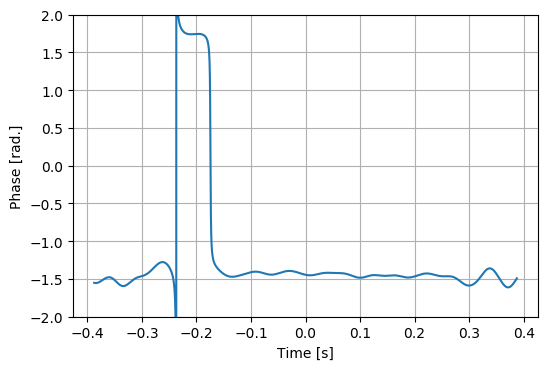

In [8]:
plt.plot(li('t'), li('phi'))
plt.xlabel('Time [s]')
plt.ylabel("Phase [rad.]")
plt.ylim(-2, 2)
plt.grid()

From the plot, we can see the correct phase is roughly -1.5 radians (The phase "reverses" by $\pi$, to +1.6 radians when the sign of the signal changes). We can phase the lock-in with  three functions:

`autophase`: performs a best-fit to minimize the phase difference, taking into account phase reversals, over the time range `ti` to `tf`.

`phase`: performs a simple least-squares fit to pick the optimal `phi0`, over the time range `ti` to `tf`.

`manual_phase`: Calculate output channels `X`, `Y` for a manually selected `phi0`.

By default, `autophase`, and `phase` also updates the reference frequency to correct any drift in the phase. This can be turned off by using the option, `adjust_f0=False`.

In [9]:
li.autophase()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1


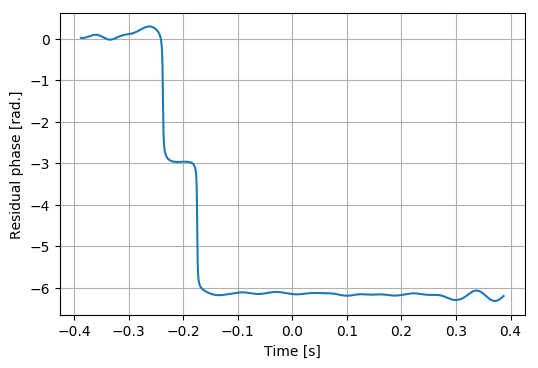

In [10]:
plt.plot(li('t'), li('dphi'))
plt.grid()
plt.xlabel('Time [s]')
plt.ylabel("Residual phase [rad.]")

In [14]:
print(li.t.size)
print(li('t').size)

10000
7751


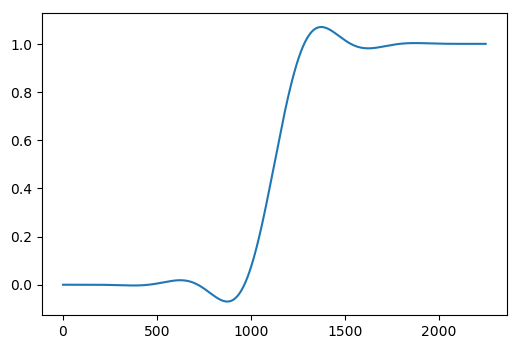

In [21]:
plt.plot(np.cumsum(li.fir))

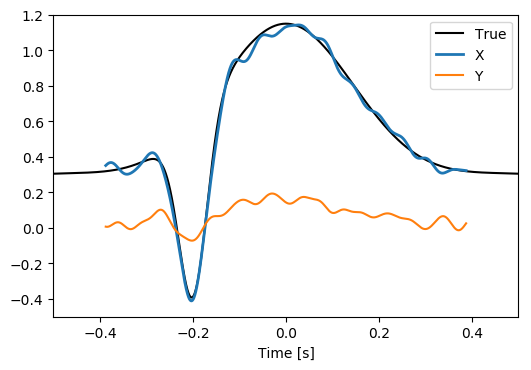

In [12]:
plt.plot(t, m_noiseless, 'k', linewidth=1.5, label="True")
plt.plot(li('t'), li('X'), linewidth=2, label="X")
plt.plot(li('t'), li('Y'), linewidth=1.5, label="Y")
plt.legend()
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 1.2)
plt.xlabel('Time [s]')

The lock-in X channel output is displayed in the above plot, compared to the actual signal.
A few things to note:

- The lock-in output is available over only a portion of the input time array, because of the length of the finite impulse response (FIR) filter. To reduce the missing portion of the signal, reduce `coeff_ratio` in the lock argument.